In [1]:
import pandas as pd
import scipy as sc

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline

In [2]:
def prepare_plot():
    """
    Set up general plot aesthetics to be used for including figures in a manuscript or talk.
    These defaults are possibly too large for interactive use.
    This function should be called before `paper_plot`.
    """
    sns.set()
    # Increase font size and linewidth
    sns.set_context("talk")
    sns.set_style("whitegrid")
    # Use LaTeX, setup to use Helvetica. This can be safely commented to make
    # the installation footprint of running this code smaller -- for example,
    # in Docker.
    mpl.rc('text', usetex=True)
    mpl.rcParams['text.latex.preamble'] = [
        r'\usepackage{amsmath}',
        r'\usepackage{helvet}',
        r'\usepackage[EULERGREEK]{sansmath}',
        r'\sansmath',
        r'\renewcommand{\familydefault}{\sfdefault}',
        r'\usepackage[T1]{fontenc}',
        r'\usepackage{graphicx}'
    ]

def paper_plot(fig, adjustment=0, scientific=False, save=False, filename=None,
               raster=False, label_pad=True):
    """
    Take a prepared figure and make additional adjustments for inclusion in manuscript:
    mostly tick thickness, length, and label padding, and include only the left and the bottom
    axis spines. It would be nice to force the axes to end on a major tick, but I haven't
    figured out how to do that yet.
    """
    for ax in fig.axes:
        # Increase padding
        ax.tick_params(which='major', direction='out', length=10, pad=10)
        ax.tick_params(which='minor', direction='out', length=5)
        # If plotting with pi, increase the x tick size specifically
        # ax.tick_params(axis='x', labelsize=40, pad=-10)
        # Increase tick thickness
        ax.xaxis.set_tick_params(width=2)
        ax.yaxis.set_tick_params(width=2)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        if label_pad:
            # Increase padding
            ax.xaxis.labelpad = 15
            ax.yaxis.labelpad = 15
        # Make the background color white
        facecolor = 'white'
        if facecolor is False:
            facecolor = fig.get_facecolor()
        alpha = 1
        color_with_alpha = colorConverter.to_rgba(facecolor, alpha)
        fig.patch.set_facecolor(color_with_alpha)
        # Stick the scientific notation into the axis label, instead of the
        # default position which in the corner, which really makes no sense.
        if ax.xaxis.get_scale() == 'linear':
            if scientific:
                pretty_label(ax)
            ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
            ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        elif ax.xaxis.get_scale() == 'log':
            pass
        # For scatter plots, where points get cut off
        if adjustment != 0:
            x0, x1, y0, y1 = ax.axis()
            ax.xaxis((x0 - adjustment,
                      x1 + adjustment,
                      y0,
                      y1
                     ))
        # Make axes thicker
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)
    if save:
        plt.savefig(filename + '.png', dpi=300, bbox_inches='tight')
        plt.savefig(filename + '.svg', dpi=300, bbox_inches='tight')


In [3]:
prepare_plot()

In [4]:
import numpy as np
import scipy as sc


def summarize(x, y):

    summary_statistics = np.empty(8)
    # Slope, intercept, R
    summary_statistics[0], summary_statistics[1], summary_statistics[
        2
    ], pval, stderr = sc.stats.linregress(x, y)
    # R**2
    summary_statistics[3] = summary_statistics[2] ** 2
    # RMSE
    summary_statistics[4] = np.sqrt(np.mean((y - x) ** 2))
    # MSE
    summary_statistics[5] = np.mean(y - x)
    # MUE
    summary_statistics[6] = np.mean(np.absolute(y - x))
    # Tau
    summary_statistics[7], prob = sc.stats.kendalltau(x, y)

    return summary_statistics


def bootstrap(
    x, x_sem, y, y_sem, cycles=1000, with_replacement=True, with_uncertainty=True
):
    summary_statistics = np.empty((cycles, 8))
    for cycle in range(cycles):
        new_x = np.empty_like(x)
        new_y = np.empty_like(y)
        for index in range(len(x)):
            if with_replacement:
                j = np.random.randint(len(x))
            else:
                j = index
            if with_uncertainty and x_sem is not None:
                new_x[index] = np.random.normal(x[j], x_sem[j])
            elif with_uncertainty and x_sem is None:
                new_x[index] = x[j]
            if with_uncertainty and y_sem is not None:
                new_y[index] = np.random.normal(y[j], y_sem[j])
            elif with_uncertainty and y_sem is None:
                new_y[index] = y[j]
        summary_statistics[cycle] = summarize(new_x, new_y)

    results = {
        "mean": {
            "slope": np.mean(summary_statistics[:, 0]),
            "intercept": np.mean(summary_statistics[:, 1]),
            "R": np.mean(summary_statistics[:, 2]),
            "R**2": np.mean(summary_statistics[:, 3]),
            "RMSE": np.mean(summary_statistics[:, 4]),
        },
        "sem": {
            "slope": np.std(summary_statistics[:, 0]),
            "intercept": np.std(summary_statistics[:, 1]),
            "R": np.std(summary_statistics[:, 2]),
            "R**2": np.std(summary_statistics[:, 3]),
            "RMSE": np.std(summary_statistics[:, 4]),
        },
    }
    return results


In [5]:
def thermodynamic_bootstrap(
    x, x_sem, y, y_sem, cycles=1000, with_replacement=True, with_uncertainty=True
):
    summary_statistics = np.empty((cycles))
    R = 1.987204118e-3 # kcal/mol-K
    temperature = 300  # K
    beta = 1.0 / (R * temperature)

    for cycle in range(cycles):
        new_x = np.empty_like(x)
        new_y = np.empty_like(y)

        if with_uncertainty and x_sem is not None:
            new_x = np.random.normal(x, x_sem)
        elif with_uncertainty and x_sem is None:
            new_x = x
        if with_uncertainty and y_sem is not None:
            new_y = np.random.normal(y, y_sem)
        elif with_uncertainty and y_sem is None:
            new_y = y
        summary_statistics[cycle] = -R * temperature * np.log(np.exp(-beta * new_x) + np.exp(-beta * new_y))
      
    results = {
        "mean": np.mean(summary_statistics),
        "sem": np.std(summary_statistics)
    }
    return results

In [6]:
smirnoff_vs_bgbg = pd.read_csv("results/enthalpy/results.csv")
pre_enthalpy = pd.read_csv("results/pre-enthalpy/results.csv")

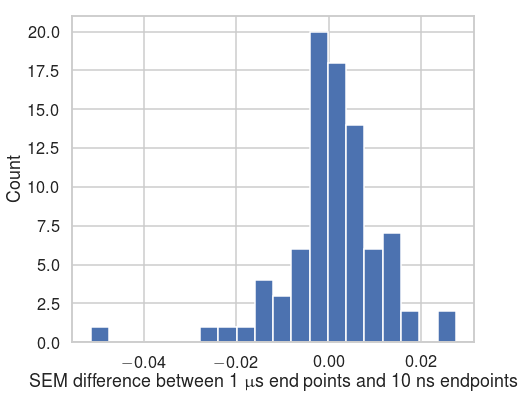

In [82]:
fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
ax.hist(smirnoff_vs_bgbg["smirnoff_sem"] - pre_enthalpy["smirnoff_sem"], bins=20)
ax.set_xlabel("SEM difference between 1 $\mu$s end points and 10 ns end points")
ax.set_ylabel("Count")

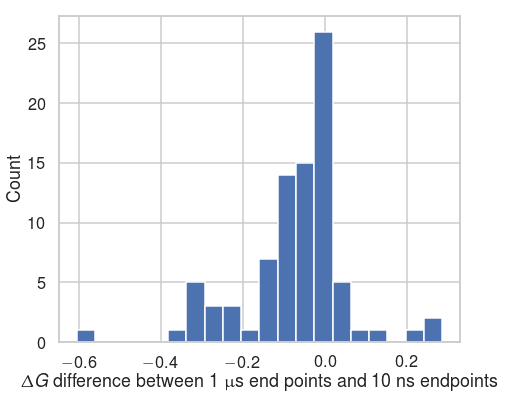

In [83]:
fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
ax.hist(smirnoff_vs_bgbg["smirnoff_fe"] - pre_enthalpy["smirnoff_fe"], bins=20)
ax.set_xlabel("$\Delta G$ difference between 1 $\mu$s end points and 10 ns end points")
ax.set_ylabel("Count")

In [76]:
smirnoff_vs_bgbg[smirnoff_vs_bgbg["system"] == "a-coc-p"]

,Unnamed: 0,system,smirnoff_fe,smirnoff_sem,bgbg_tip3p_fe,bgbg_tip3p_sem,guest_type
8,8,a-coc-p,0.466613,0.29629,0.342746,0.307959,cyclic_alcohols


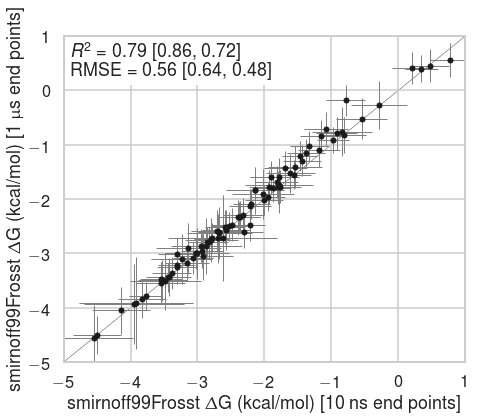

In [61]:
statistics = bootstrap(
    smirnoff_vs_bgbg["smirnoff_fe"],
    smirnoff_vs_bgbg["smirnoff_sem"],
    pre_enthalpy["smirnoff_fe"],
    pre_enthalpy["smirnoff_sem"],
    cycles=10,
)


fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
ax.errorbar(
    smirnoff_vs_bgbg["smirnoff_fe"],
    pre_enthalpy["smirnoff_fe"],
    xerr=smirnoff_vs_bgbg["smirnoff_sem"],
    yerr=pre_enthalpy["smirnoff_sem"],
    ms=5,
    fmt="o",
    c="k",
    ecolor="0.5",
    elinewidth=1,
)

ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-5, 1)
ax.set_xlim(-5, 1)
ax.set_xlabel("smirnoff99Frosst $\Delta$G (kcal/mol) [10 ns end points]", labelpad=5)
ax.set_ylabel("smirnoff99Frosst $\Delta$G (kcal/mol) [1 $\mu$s end points]", labelpad=5)
bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.0, alpha=1)
text = f"$R^2$ = {statistics['mean']['R**2']:0.2f} [{statistics['mean']['R**2']+1.96*statistics['sem']['R**2']:0.2f}, {statistics['mean']['R**2']-1.96*statistics['sem']['R**2']:0.2f}]"
text += "\n"
text += f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
ax.annotate(
    text,
    xy=(-5 + 0.11, 1 - 0.11),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
)


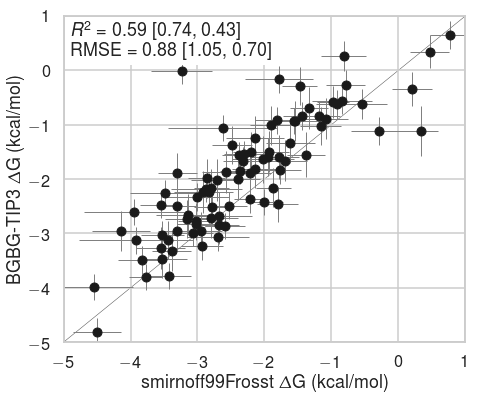

In [7]:
statistics = bootstrap(smirnoff_vs_bgbg["smirnoff_fe"],
                       smirnoff_vs_bgbg["smirnoff_sem"],
                       smirnoff_vs_bgbg["bgbg_tip3p_fe"],
                       smirnoff_vs_bgbg["bgbg_tip3p_sem"],
                       cycles=1000)



fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
ax.errorbar(
    smirnoff_vs_bgbg["smirnoff_fe"],
    smirnoff_vs_bgbg["bgbg_tip3p_fe"],
    xerr=smirnoff_vs_bgbg["smirnoff_sem"],
    yerr=smirnoff_vs_bgbg["bgbg_tip3p_sem"],
    fmt="o",
    c="k",
    ecolor="0.5",
    elinewidth=1,
)

ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-5, 1)
ax.set_xlim(-5, 1)
ax.set_xlabel("smirnoff99Frosst $\Delta$G (kcal/mol)", labelpad=5)
ax.set_ylabel("BGBG-TIP3 $\Delta$G (kcal/mol)", labelpad=5)
bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.0, alpha=1)
text = f"$R^2$ = {statistics['mean']['R**2']:0.2f} [{statistics['mean']['R**2']+1.96*statistics['sem']['R**2']:0.2f}, {statistics['mean']['R**2']-1.96*statistics['sem']['R**2']:0.2f}]"
text += "\n"
text += f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
ax.annotate(
    text,
    xy=(-5 + 0.11, 1 - 0.11),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
)

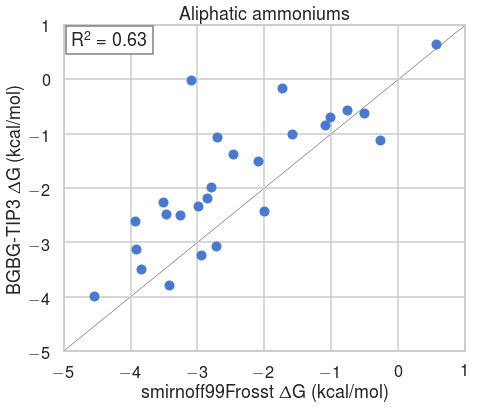

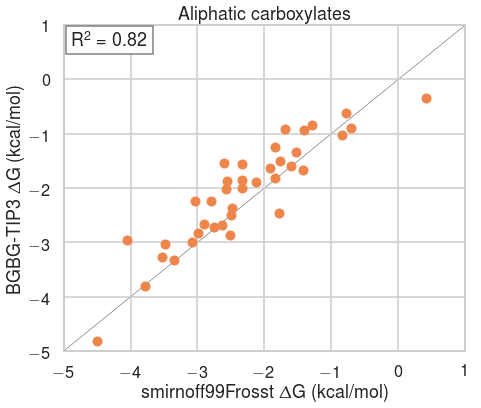

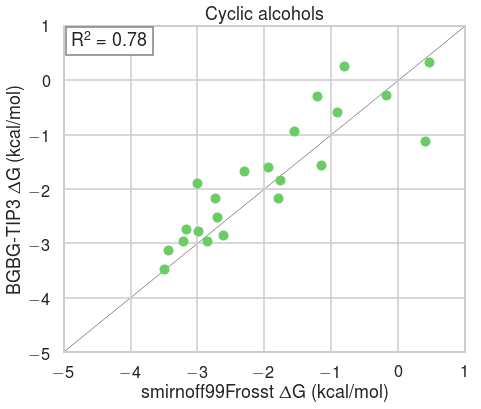

In [263]:
guest_types = smirnoff_vs_bgbg["guest_type"].unique()
colors = sns.color_palette("muted")

for index, guest_type in enumerate(guest_types):
    df = smirnoff_vs_bgbg[smirnoff_vs_bgbg["guest_type"] == guest_type]
    r_squared = sc.stats.pearsonr(df["smirnoff_fe"], df["bgbg_tip3p_fe"])[0] ** 2
    
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
    ax.errorbar(
        df["smirnoff_fe"],
        df["bgbg_tip3p_fe"],
        # xerr=df["smirnoff_sem"],
        # yerr=df["bgbg_tip3p_sem"],
        fmt="o",
        c=colors[index],
        ecolor="0.5",
        elinewidth=1,
        label=f"R$^2$ = {r_squared:02f}",
    )

    ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
    ax.set_ylim(-5, 1)
    ax.set_xlim(-5, 1)
    ax.set_xlabel("smirnoff99Frosst $\Delta$G (kcal/mol)", labelpad=5)
    ax.set_ylabel("BGBG-TIP3 $\Delta$G (kcal/mol)", labelpad=5)
    guest_string = " ".join(guest_type.split("_"))
    guest_string = guest_string[0].upper() + guest_string[1:]
    ax.set_title(guest_string)
    bbox_props = dict(boxstyle="square", fc="w", ec="k", alpha=0.5)
    bbox_props = dict(boxstyle="square", fc="w", ec="0.5", alpha=1)
    ax.annotate(
        f"R$^2$ = {r_squared:0.2f}",
        xy=(0.02, 0.94),
        xycoords="axes fraction",
        size=18,
        bbox=bbox_props,
    )
    # paper_plot(fig)


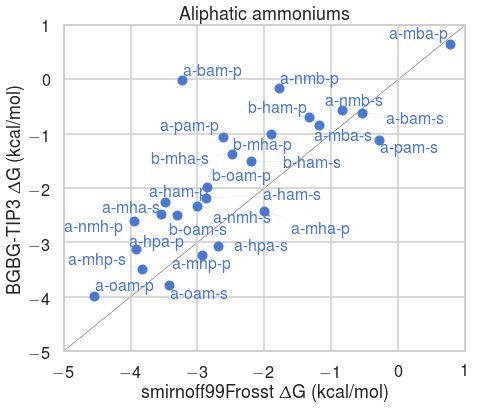

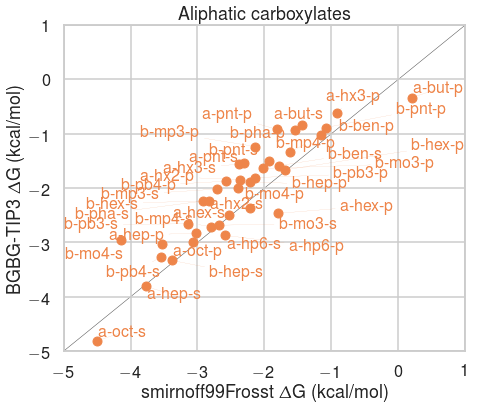

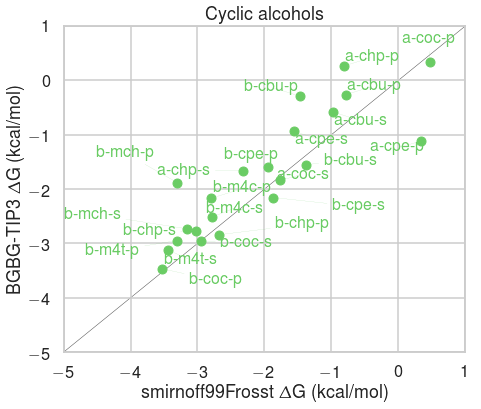

In [73]:
from adjustText import adjust_text

guest_types = smirnoff_vs_bgbg["guest_type"].unique()
colors = sns.color_palette("muted")

for index, guest_type in enumerate(guest_types):
    df = smirnoff_vs_bgbg[smirnoff_vs_bgbg["guest_type"] == guest_type]
    r_squared = sc.stats.pearsonr(df["smirnoff_fe"], df["bgbg_tip3p_fe"])[0] ** 2

    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
    ax.errorbar(
        df["smirnoff_fe"],
        df["bgbg_tip3p_fe"],
        # xerr=df["smirnoff_sem"],
        # yerr=df["bgbg_tip3p_sem"],
        fmt="o",
        c=colors[index],
        ecolor="0.5",
        elinewidth=1,
        label=f"R$^2$ = {r_squared:02f}",
    )


    ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
    ax.set_ylim(-5, 1)
    ax.set_xlim(-5, 1)
    ax.set_xlabel("smirnoff99Frosst $\Delta$G (kcal/mol)", labelpad=5)
    ax.set_ylabel("BGBG-TIP3 $\Delta$G (kcal/mol)", labelpad=5)
    guest_string = " ".join(guest_type.split("_"))
    guest_string = guest_string[0].upper() + guest_string[1:]
    ax.set_title(guest_string)
    bbox_props = dict(boxstyle="square", fc="w", ec="k", alpha=0.5)
    text = [
        plt.text(
            row["smirnoff_fe"],
            row["bgbg_tip3p_fe"],
            f"{row['system']}",
            size=16,
            color=colors[index],
        )
        for _, row in df.iterrows()
    ]
    adjust_text(
        text,
        #expand_points=(1.1, 1.3),
        arrowprops=dict(color=colors[index], arrowstyle="-", lw=0.1),
        #bbox=dict(pad=5),
        lim=500
    )

    # ax.annotate(f"R$^2$ = {r_squared:0.2f}", xy=(-4.8, 0.7), size=16, bbox=bbox_props)
    # paper_plot(fig)


In [129]:
smirnoff_vs_bgbg["short_system"] = ["-".join(row["system"].split("-")[0:2]) for _, row in smirnoff_vs_bgbg.iterrows()]

In [130]:
combined_smirnoff = pd.DataFrame()

for hg in smirnoff_vs_bgbg["short_system"].unique():
    df = smirnoff_vs_bgbg[smirnoff_vs_bgbg["short_system"] == hg]
    for _, row in df.iterrows():
        if "p" in row["system"].split("-")[2]:
            primary_fe = row["smirnoff_fe"]
            primary_sem = row["smirnoff_sem"]
            guest_type = row["guest_type"]
        else:
            secondary_fe = row["smirnoff_fe"]
            secondary_sem = row["smirnoff_sem"]
    results = thermodynamic_bootstrap(primary_fe, primary_sem,
                           secondary_fe, secondary_sem)
    print(f"{hg} P: {primary_fe:+0.4f} ± {primary_sem:+0.2f} S: {secondary_fe:+0.2f} ± {secondary_sem:+0.2f} → Boot: {results['mean']:+0.2f} ± {results['sem']:+0.2f}")
    
    combined_smirnoff = combined_smirnoff.append(pd.DataFrame({'system': hg,
                                 'smirnoff_fe' : results['mean'],
                                 'smirnoff_sem': results['sem'],
                                 'guest_type': guest_type
                                 }, index=[0]), ignore_index=True)

a-bam P: -3.2355 ± +0.45 S: -0.54 ± +0.38 → Boot: -3.25 ± +0.44
a-but P: +0.2037 ± +0.30 S: -1.44 ± +0.29 → Boot: -1.49 ± +0.26
a-cbu P: -0.7880 ± +0.29 S: -0.98 ± +0.24 → Boot: -1.33 ± +0.18
a-chp P: -0.8140 ± +0.34 S: -2.32 ± +0.31 → Boot: -2.38 ± +0.27
a-coc P: +0.4666 ± +0.30 S: -1.76 ± +0.30 → Boot: -1.78 ± +0.29
a-cpe P: +0.3434 ± +0.25 S: -1.56 ± +0.26 → Boot: -1.59 ± +0.25
a-ham P: -3.4785 ± +0.53 S: -2.87 ± +0.53 → Boot: -3.75 ± +0.42
a-hep P: -3.0243 ± +0.29 S: -3.78 ± +0.25 → Boot: -3.94 ± +0.20
a-hex P: -1.8034 ± +0.31 S: -2.52 ± +0.26 → Boot: -2.70 ± +0.22
a-hp6 P: -2.5862 ± +0.30 S: -3.06 ± +0.30 → Boot: -3.31 ± +0.22
a-hpa P: -3.9121 ± +0.85 S: -2.70 ± +0.46 → Boot: -4.06 ± +0.68
a-hx2 P: -2.3665 ± +0.30 S: -2.22 ± +0.24 → Boot: -2.74 ± +0.20
a-hx3 P: -0.9231 ± +0.31 S: -2.38 ± +0.25 → Boot: -2.43 ± +0.24
a-mba P: +0.7655 ± +0.30 S: -1.19 ± +0.32 → Boot: -1.23 ± +0.30
a-mha P: -2.0097 ± +0.28 S: -3.55 ± +0.31 → Boot: -3.62 ± +0.28
a-mhp P: -2.9319 ± +0.31 S: -3.83 ± +0.3

In [131]:
combined_bgbg = pd.DataFrame()

for hg in smirnoff_vs_bgbg["short_system"].unique():
    df = smirnoff_vs_bgbg[smirnoff_vs_bgbg["short_system"] == hg]
    for _, row in df.iterrows():
        if "p" in row["system"].split("-")[2]:
            primary_fe = row["bgbg_tip3p_fe"]
            primary_sem = row["bgbg_tip3p_sem"]
            guest_type = row["guest_type"]
        else:
            secondary_fe = row["bgbg_tip3p_fe"]
            secondary_sem = row["bgbg_tip3p_sem"]
    results = thermodynamic_bootstrap(primary_fe, primary_sem,
                           secondary_fe, secondary_sem)
    print(f"{hg} P: {primary_fe:+0.4f} ± {primary_sem:+0.2f} S: {secondary_fe:+0.2f} ± {secondary_sem:+0.2f} → Boot: {results['mean']:+0.2f} ± {results['sem']:+0.2f}")
    
    combined_bgbg = combined_bgbg.append(pd.DataFrame({'system': hg,
                                 'bgbg_tip3p_fe' : results['mean'],
                                 'bgbg_tip3p_sem': results['sem'],
                                 'guest_type': guest_type
                                 }, index=[0]), ignore_index=True)

a-bam P: -0.0161 ± +0.23 S: -0.62 ± +0.27 → Boot: -0.81 ± +0.21
a-but P: -0.3350 ± +0.31 S: -0.85 ± +0.26 → Boot: -1.08 ± +0.20
a-cbu P: -0.2649 ± +0.27 S: -0.58 ± +0.30 → Boot: -0.88 ± +0.22
a-chp P: +0.2635 ± +0.27 S: -1.67 ± +0.25 → Boot: -1.67 ± +0.24
a-coc P: +0.3427 ± +0.31 S: -1.84 ± +0.25 → Boot: -1.86 ± +0.25
a-cpe P: -1.1175 ± +0.47 S: -0.94 ± +0.24 → Boot: -1.51 ± +0.29
a-ham P: -2.2582 ± +0.24 S: -2.18 ± +0.24 → Boot: -2.66 ± +0.17
a-hep P: -2.8243 ± +0.25 S: -3.81 ± +0.24 → Boot: -3.92 ± +0.20
a-hex P: -2.4652 ± +0.33 S: -2.49 ± +0.24 → Boot: -2.92 ± +0.21
a-hp6 P: -2.8687 ± +0.24 S: -2.99 ± +0.25 → Boot: -3.37 ± +0.18
a-hpa P: -3.1280 ± +0.24 S: -3.07 ± +0.25 → Boot: -3.54 ± +0.18
a-hx2 P: -1.8456 ± +0.25 S: -2.37 ± +0.24 → Boot: -2.60 ± +0.19
a-hx3 P: -0.6223 ± +0.27 S: -1.56 ± +0.24 → Boot: -1.69 ± +0.21
a-mba P: +0.6530 ± +0.26 S: -0.84 ± +0.27 → Boot: -0.90 ± +0.25
a-mha P: -2.4213 ± +0.24 S: -2.48 ± +0.24 → Boot: -2.88 ± +0.18
a-mhp P: -3.2377 ± +0.25 S: -3.49 ± +0.2

In [132]:
experimental_values = """a-nmb	-1.69	0.02
a-mba	-1.76	0.02
a-pam	-2.72	0.00
a-ham	-3.53	0.00
a-nmh	-3.52	0.01
a-mha	-3.60	0.00
a-hpa	-4.14	0.00
a-mhp	-4.17	0.00
a-oam	-4.61	0.01
b-ham	-2.49	0.08
b-mha	-2.56	0.07
b-oam	-3.59	0.12
a-cbu	-2.02	0.02
a-cpe	-2.13	0.02
a-chp	-2.51	0.06
a-coc	-3.23	1.14
b-cbu	-1.55	0.17
b-cpe	-3.05	0.01
b-mch	-4.18	0.01
b-m4c	-4.32	0.01
b-m4t	-4.54	0.01
b-chp	-4.56	0.01
b-coc	-4.97	0.04
a-but	-1.51	0.04
a-pnt	-2.60	0.01
a-hex	-3.38	0.01
a-hx2	-3.34	0.01
a-hx3	-3.01	0.01
a-hep	-3.99	0.01
a-hp6	-3.60	0.00
a-oct	-4.62	0.02
b-pnt	-1.27	0.32
b-hex	-2.28	0.03
b-hep	-3.39	0.18
b-ben	-1.64	0.02
b-pha	-1.70	0.05
b-mp3	-1.46	0.04
b-mp4	-2.19	0.01
b-mo3	-2.16	0.01
b-mo4	-2.51	0.01
b-pb3	-3.52	0.01
b-pb4	-3.60	0.02"""

In [133]:
experimental_data = pd.DataFrame()
for row in experimental_values.split("\n"):
    experimental_data = experimental_data.append(pd.DataFrame({'system': row.split('\t')[0],
                                 'exp_fe' : float(row.split('\t')[1]),
                                 'exp_sem': float(row.split('\t')[2]),
                                 }, index=[0]), ignore_index=True)

In [134]:
all_data = pd.merge(combined_smirnoff, experimental_data, on="system")

In [135]:
all_data = pd.merge(combined_bgbg, all_data, on=["system", "guest_type"])

In [150]:
all_data.to_csv("results/enthalpy/all_data.csv")

In [148]:
statistics = bootstrap(
    all_data["exp_fe"],
    all_data["exp_sem"],
    all_data["smirnoff_fe"],
    all_data["smirnoff_sem"],
    cycles=10000,
)

fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
ax.errorbar(
    all_data["exp_fe"],
    all_data["smirnoff_fe"],
    xerr=all_data["exp_sem"],
    yerr=all_data["smirnoff_sem"],
    fmt="o",
    c="k",
    ecolor="0.5",
    elinewidth=1,
    label=f"R$^2$ = {r_squared:0.2f}",
)

ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-6, 0)
ax.set_xlim(-6, 0)
ax.set_ylabel("smirnoff99Frosst $\Delta$G (kcal/mol)", labelpad=5)
ax.set_xlabel("Experimental $\Delta$G (kcal/mol)", labelpad=5)
bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.0, alpha=1)
text = f"$R^2$ = {statistics['mean']['R**2']:0.2f} [{statistics['mean']['R**2']+1.96*statistics['sem']['R**2']:0.2f}, {statistics['mean']['R**2']-1.96*statistics['sem']['R**2']:0.2f}]"
text += "\n"
text += f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
ax.annotate(
    text,
    xy=(-6 + 0.11, 0 - 0.11),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
    linespacing = 1.8
)


KeyboardInterrupt: 

In [145]:
statistics = bootstrap(
    all_data["exp_fe"],
    all_data["exp_sem"],
    all_data["bgbg_tip3p_fe"],
    all_data["bgbg_tip3p_sem"],
    cycles=1000,
)


colors = {'aliphatic_ammoniums': 'darkorange',
          'cyclic_alcohols': 'cornflowerblue',
          'aliphatic_carboxylates': 'purple'
         }
plot_colors = [colors[i] for i in all_data["guest_type"].values]
all_data["color"] = plot_colors

fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
ax.errorbar(
    all_data["exp_fe"],
    all_data["bgbg_tip3p_fe"],
    xerr=all_data["exp_sem"],
    yerr=all_data["bgbg_tip3p_sem"],
    fmt="o",
    c=all_data["color"],
    ecolor="0.5",
    elinewidth=1,
    label=f"R$^2$ = {r_squared:0.2f}",
)

ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-6, 0)
ax.set_xlim(-6, 0)
ax.set_ylabel("BGBG-TIP3P (replotting) $\Delta$G (kcal/mol)", labelpad=5)
ax.set_xlabel("Experimental $\Delta$G (kcal/mol)", labelpad=5)
bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.0, alpha=1)
text = f"$R^2$ = {statistics['mean']['R**2']:0.2f} [{statistics['mean']['R**2']+1.96*statistics['sem']['R**2']:0.2f}, {statistics['mean']['R**2']-1.96*statistics['sem']['R**2']:0.2f}]"
text += "\n"
text += f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
ax.annotate(
    text,
    xy=(-6 + 0.11, 0 - 0.11),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
    linespacing = 1.8
)


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f80cbe148c8> (for post_execute):


AttributeError: 'Series' object has no attribute 'lower'

AttributeError: 'Series' object has no attribute 'lower'

In [146]:
all_data

,system,bgbg_tip3p_fe,bgbg_tip3p_sem,guest_type,smirnoff_fe,smirnoff_sem,exp_fe,exp_sem,color
0,a-but,-1.084504,0.199796,aliphatic_carboxylates,-1.491993,0.262354,-1.51,0.04,purple
1,a-cbu,-0.879585,0.219707,cyclic_alcohols,-1.331736,0.184635,-2.02,0.02,cornflowerblue
2,a-chp,-1.673949,0.244269,cyclic_alcohols,-2.384028,0.274455,-2.51,0.06,cornflowerblue
3,a-coc,-1.855948,0.248055,cyclic_alcohols,-1.779934,0.291748,-3.23,1.14,cornflowerblue
4,a-cpe,-1.505459,0.285651,cyclic_alcohols,-1.594558,0.246298,-2.13,0.02,cornflowerblue
5,a-ham,-2.662551,0.171992,aliphatic_ammoniums,-3.748261,0.415286,-3.53,0.00,darkorange
6,a-hep,-3.918150,0.204337,aliphatic_carboxylates,-3.938872,0.198782,-3.99,0.01,purple
7,a-hex,-2.918343,0.211477,aliphatic_carboxylates,-2.696030,0.218861,-3.38,0.01,purple
8,a-hp6,-3.369568,0.175517,aliphatic_carboxylates,-3.305537,0.221237,-3.60,0.00,purple
9,a-hpa,-3.543916,0.176422,aliphatic_ammoniums,-4.057761,0.680091,-4.14,0.00,darkorange


Do we get the same statistics as Niel...?

In [137]:
statistics

{'mean': {'slope': 0.717436444670423,
  'intercept': -0.36395017660465356,
  'R': 0.75959327399830145,
  'R**2': 0.58102135528031873,
  'RMSE': 0.85539692145712309},
 'sem': {'slope': 0.1056625049813317,
  'intercept': 0.34301836586535062,
  'R': 0.063556379513469069,
  'R**2': 0.093704115824433679,
  'RMSE': 0.085542878826067204}}

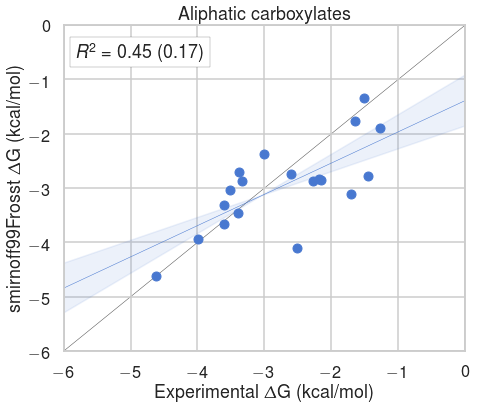

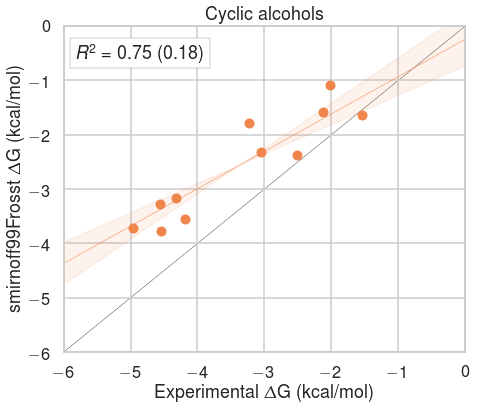

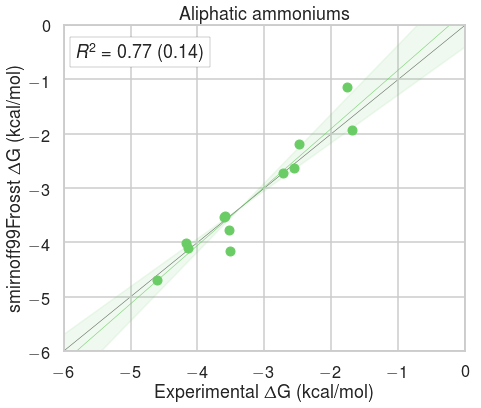

In [460]:
guest_types = all_data["guest_type"].unique()
colors = sns.color_palette("muted")

for index, guest_type in enumerate(guest_types):
    df = all_data[all_data["guest_type"] == guest_type]
    statistics = bootstrap(df["exp_fe"].values,
                       df["exp_sem"].values,
                           df["smirnoff_fe"].values,
                       df["smirnoff_sem"].values,
                       cycles=1000)
    
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
    ax.errorbar(
        df["exp_fe"],
        df["smirnoff_fe"],
        # xerr=df["smirnoff_sem"],
        # yerr=df["bgbg_tip3p_sem"],
        fmt="o",
        c=colors[index],
        ecolor="0.5",
        elinewidth=1,
    )
    
    regression = statistics['mean']['slope'] * range(-50, 50) + statistics['mean']['intercept']
    ci_upper = (statistics['mean']['slope'] + statistics['sem']['slope']) * range(-50, 50) + (statistics['mean']['intercept'] + statistics['sem']['intercept'])
    ci_lower = (statistics['mean']['slope'] - statistics['sem']['slope']) * range(-50, 50) + (statistics['mean']['intercept'] - statistics['sem']['intercept'])
    ax.plot(range(-50, 50), regression, ls='-', lw=0.5, c=colors[index])
    ax.fill_between(range(-50, 50), ci_upper, ci_lower, color=colors[index], alpha=0.1 )
    
    ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
    ax.set_ylim(-6, 0)
    ax.set_xlim(-6, 0)
    ax.set_ylabel("smirnoff99Frosst $\Delta$G (kcal/mol)", labelpad=5)
    ax.set_xlabel("Experimental $\Delta$G (kcal/mol)", labelpad=5)
    guest_string = " ".join(guest_type.split("_"))
    guest_string = guest_string[0].upper() + guest_string[1:]
    ax.set_title(guest_string)
    bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.2, alpha=1)
    ax.annotate(
        f"$R^2$ = {statistics['mean']['R**2']:0.2f} ({statistics['sem']['R**2']:0.2f})",
        xy=(0.03, 0.9),
        xycoords="axes fraction",
        size=18,
        bbox=bbox_props,
    )
    # paper_plot(fig)


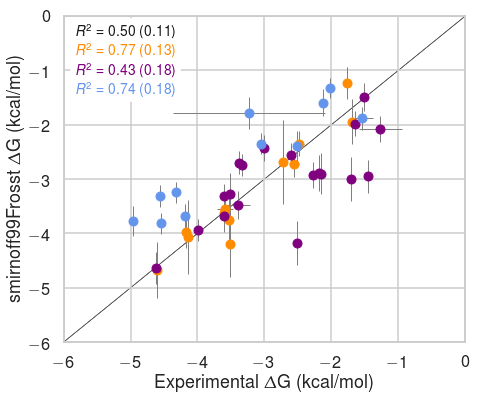

In [140]:
overall_statistics = bootstrap(all_data["smirnoff_fe"],
                       all_data["smirnoff_sem"],
                       all_data["exp_fe"],
                       all_data["exp_sem"],
                       cycles=10000)

colors = {'aliphatic_ammoniums': 'darkorange',
          'cyclic_alcohols': 'cornflowerblue',
          'aliphatic_carboxylates': 'purple'
}
all_data["color"] = [colors[i] for i in all_data["guest_type"]]

fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
bbox_props = dict(boxstyle="square", fc="w",  ec="w", alpha=1)
ax.annotate(
f"$R^2$ = {overall_statistics['mean']['R**2']:0.2f} ({overall_statistics['sem']['R**2']:0.2f})",
xy=(0.03, 0.94),
xycoords="axes fraction",
color="k",
size=14,
bbox=bbox_props,
)


for index, guest_type in enumerate(guest_types):
    df = all_data[all_data["guest_type"] == guest_type]
    statistics = bootstrap(
                       df["exp_fe"].values,
                       df["exp_sem"].values,
                       df["smirnoff_fe"].values,
                       df["smirnoff_sem"].values,
                       cycles=10000)
    
    ax.errorbar(
        df["exp_fe"],
        df["smirnoff_fe"],
        xerr=df["exp_sem"],
        yerr=df["smirnoff_sem"],
        fmt="o",
        c=colors[guest_type],
        ecolor="0.5",
        elinewidth=1,
        label=f"$R^2$ = {statistics['mean']['R**2']:0.2f} ({statistics['sem']['R**2']:0.2f})",
    )
    bbox_props = dict(boxstyle="square", fc="w",  ec="w", alpha=1)
    ax.annotate(
    f"$R^2$ = {statistics['mean']['R**2']:0.2f} ({statistics['sem']['R**2']:0.2f})",
    xy=(0.03, 0.88 - index*0.06),
    xycoords="axes fraction",
    color=colors[guest_type],
    size=14,
    bbox=bbox_props,
    )


    ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
    ax.set_ylim(-6, 0)
    ax.set_xlim(-6, 0)
    ax.set_ylabel("smirnoff99Frosst $\Delta$G (kcal/mol)", labelpad=5)
    ax.set_xlabel("Experimental $\Delta$G (kcal/mol)", labelpad=5)
#     guest_string = " ".join(guest_type.split("_"))
#     guest_string = guest_string[0].upper() + guest_string[1:]
#     ax.set_title(guest_string)
#    ax.legend()
#    handles, labels = ax.get_legend_handles_labels()
#    from matplotlib import container
#    handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
#    ax.legend(handles, labels)


# All the correlations...

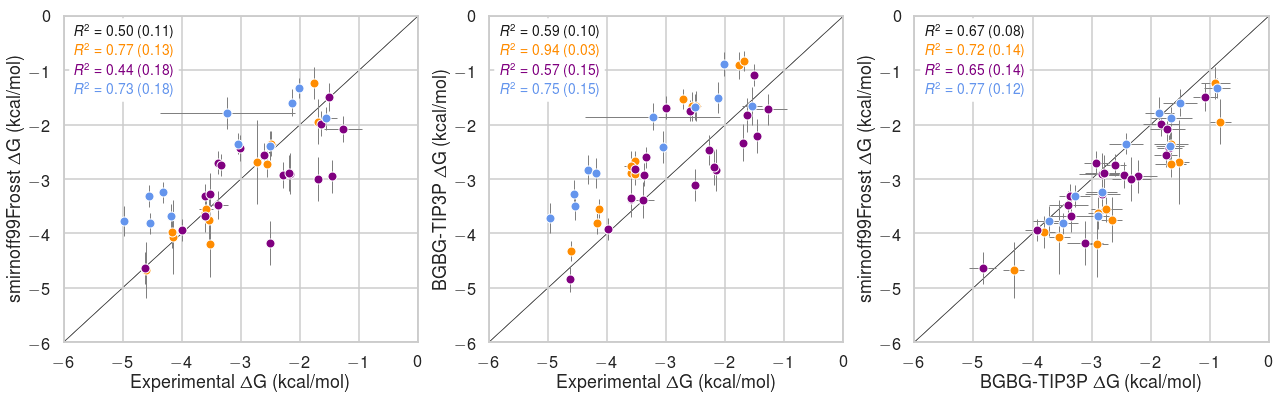

In [180]:
colors = {'aliphatic_ammoniums': 'darkorange',
          'cyclic_alcohols': 'cornflowerblue',
          'aliphatic_carboxylates': 'purple'
}
all_data["color"] = [colors[i] for i in all_data["guest_type"]]

plots = [["exp_fe", "smirnoff_fe"], 
         ["exp_fe", "bgbg_tip3p_fe", ],
         ["bgbg_tip3p_fe", "smirnoff_fe", ]]

sems = [["exp_sem", "smirnoff_sem"], 
         ["exp_sem", "bgbg_tip3p_sem", ],
         ["bgbg_tip3p_sem", "smirnoff_sem", ]]

labels = [["Experimental $\Delta$G (kcal/mol)", "smirnoff99Frosst $\Delta$G (kcal/mol)",], 
         [ "Experimental $\Delta$G (kcal/mol)", "BGBG-TIP3P $\Delta$G (kcal/mol)"],
         ["BGBG-TIP3P $\Delta$G (kcal/mol)", "smirnoff99Frosst $\Delta$G (kcal/mol)", ]]

fig, ax = plt.subplots(1, 3, figsize=(6 * 1.2 * 3, 6))
for axis, (plot, sem) in enumerate(zip(plots, sems)):

    overall_statistics = bootstrap(                   
                   all_data[plot[0]].values,
                   all_data[sem[0]].values,
                   all_data[plot[1]].values,
                   all_data[sem[1]].values,
                       cycles=1000)
    bbox_props = dict(boxstyle="square", fc="w",  ec="w", alpha=1)
    ax[axis].annotate(
    f"$R^2$ = {overall_statistics['mean']['R**2']:0.2f} ({overall_statistics['sem']['R**2']:0.2f})",
    xy=(0.03, 0.94),
    xycoords="axes fraction",
    color="k",
    size=14,
    bbox=bbox_props,
    )


    for index, guest_type in enumerate(guest_types):
        df = all_data[all_data["guest_type"] == guest_type]
        statistics = bootstrap(
                   df[plot[0]].values,
                   df[sem[0]].values,
                   df[plot[1]].values,
                   df[sem[1]].values,
                   cycles=1000)
        
        bbox_props = dict(boxstyle="square", fc="w",  ec="w", alpha=1)
        ax[axis].annotate(
        f"$R^2$ = {statistics['mean']['R**2']:0.2f} ({statistics['sem']['R**2']:0.2f})",
        xy=(0.03, 0.88 - index*0.06),
        xycoords="axes fraction",
        color=colors[guest_type],
        size=14,
        bbox=bbox_props,
        )


        ax[axis].errorbar(
            df[plot[0]],
            df[plot[1]],
            xerr=df[sem[0]],
            yerr=df[sem[1]],
            fmt="o",
            c=colors[guest_type],
            markeredgecolor="w",
            ecolor="0.5",
            elinewidth=1,
            label=f"$R^2$ = {statistics['mean']['R**2']:0.2f} ({statistics['sem']['R**2']:0.2f})",
        )


        ax[axis].plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
        ax[axis].set_ylim(-6, 0)
        ax[axis].set_xlim(-6, 0)
        ax[axis].set_ylabel(labels[axis][1], labelpad=5)
        ax[axis].set_xlabel(labels[axis][0], labelpad=5)

In [449]:
def count_simulation_time(window):
    # with open(os.path.join(window, "prod.000.in"), "r") as f:
    with open(os.path.join(window, "mdin"), "r") as f:
        read_data = f.read()
    dt = [float(i.split("=")[1][:-1]) for i in read_data.splitlines() if "dt" in i][0]
    nstlim = [
        int(i.split("=")[1][:-1]) for i in read_data.splitlines() if "nstlim" in i
    ][0]
    # trajectories = glob.glob(os.path.join(window, "prod") + "*.nc")
    trajectories = glob.glob(os.path.join(window, "traj") + "*")
    trajectories = [i for i in trajectories if "rst" not in i]
    number_trajectories = len(trajectories)

    simulation_time = dt * nstlim * number_trajectories

    return nstlim, number_trajectories, simulation_time


In [447]:
import glob
import os
windows = glob.glob("/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/smirnoff/a*")
windows += glob.glob("/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/smirnoff/p*")
for window in windows:
    print(count_simulation_time(window))

(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 1

In [450]:
windows = glob.glob("/home/dslochower/niel-kirkwood/projects/cds/wat6/bgbg-tip3p/a-bam-p/a*")
windows += glob.glob("/home/dslochower/niel-kirkwood/projects/cds/wat6/bgbg-tip3p/a-bam-p/u*")
for window in windows:
    print(count_simulation_time(window))

(1250000, 200, 1000000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 2, 10000.0)
(1250000, 2, 10000.0)
(1250000, 1, 5000.0)
(1250000, 5, 25000.0)
(1250000, 3, 15000.0)
(1250000, 2, 10000.0)
(1250000, 4, 20000.0)
(1250000, 3, 15000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 2, 10000.0)
(1250000, 4, 20000.0)
(1250000, 6, 30000.0)
(1250000, 1, 5000.0)
(1250000, 2, 10000.0)
(1250000, 2, 10000.0)
(1250000, 1, 5000.0)
(1250000, 3, 15000.0)
(1250000, 3, 15000.0)
(1250000, 2, 10000.0)
(1250000, 6, 30000.0)
(1250000, 8, 40000.0)
(1250000, 2, 10000.0)
(1250000, 2, 10000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 3, 15000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 2, 10000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000